In [82]:
# https://www.kaggle.com/datasets/yasserh/titanic-dataset/data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  roc_curve, auc

%matplotlib inline

# Load the dataset
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
print(data.info()) # shows columns names, number of non-null values and data type
print(data.isnull().sum()) # shows number of null values in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6

# Feature Selection/Creation

Handled feature creation/selection first because 'Age' column will be filled based on 'Title'(to be created) column .

### Why?
Because I can use the passenger's title appeared in 'Name' column to determin the missing age better than randomly filling it with median of the whole column and no the median of the title itself.

In [84]:
df = data.copy()

In [85]:
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+\.)', expand=False)
df['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.'], dtype=object)

In [86]:
df['Title'] = df['Title'].replace(['Sir.'], 'Mr.')
df['Title'] = df['Title'].replace(['Mme.', 'Lady.', 'Countess.'], 'Mrs.')
df['Title'] = df['Title'].replace(['Ms.', 'Mlle.'], 'Miss.')
df['Title'] = df['Title'].replace(['Dr.', 'Rev.', 'Major.', 'Col.', 'Capt.', 'Jonkheer.', 'Don.'], 'Rare')
df['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Rare'], dtype=object)

In [87]:
df.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'] , axis=1, inplace=True)

In [88]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr.
1,1,1,female,38.0,1,0,71.2833,C,Mrs.
2,1,3,female,26.0,0,0,7.9250,S,Miss.
3,1,1,female,35.0,1,0,53.1000,S,Mrs.
4,0,3,male,35.0,0,0,8.0500,S,Mr.


# Handle Missing Values


In [89]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2
Title,0


In [90]:
df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median')) # cus mean is sensitive to outliers.

imputer_embarked = SimpleImputer(strategy='most_frequent')
df[['Embarked']] = imputer_embarked.fit_transform(df[['Embarked']])

df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0
Title,0


# Encoding


Based on the unique values, I'll choose the encoding method.



In [91]:
for col in df.select_dtypes(include='object').columns:
    print(f"'{col}': {df[col].unique()}")

'Sex': ['male' 'female']
'Embarked': ['S' 'C' 'Q']
'Title': ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Rare']


Binary mapping for 'Sex' column.

In [92]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

One-hot Encoding

In [93]:
df = pd.get_dummies(df, columns=['Title', 'Embarked'], drop_first=True)

In [94]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,True,False,False,False,True
1,1,1,1,38.0,1,0,71.2833,False,False,True,False,False,False
2,1,3,1,26.0,0,0,7.9250,True,False,False,False,False,True
3,1,1,1,35.0,1,0,53.1000,False,False,True,False,False,True
4,0,3,0,35.0,0,0,8.0500,False,True,False,False,False,True


# Spliting



In [95]:
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(y.unique())

Training set size: (712, 12)
Testing set size: (179, 12)
[0 1]


# Scaling


In [96]:
sc = StandardScaler()
cols_to_scale = ['Age', 'Fare']

X_train[cols_to_scale] = sc.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = sc.transform(X_test[cols_to_scale])

In [97]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Embarked_Q,Embarked_S
692,3,0,0.036020,0,0,0.513812,False,True,False,False,False,True
481,2,0,0.036020,0,0,-0.662563,False,True,False,False,False,True
527,1,0,0.036020,0,0,3.955399,False,True,False,False,False,True
855,3,1,-0.868936,0,1,-0.467874,False,False,True,False,False,True
801,2,1,0.111433,1,1,-0.115977,False,False,True,False,False,True


# OVER SAMPLING

In [98]:
print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))

273
439
439
439


# Training

In [99]:
model = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=5
)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

### Actual vs Predicted comparison


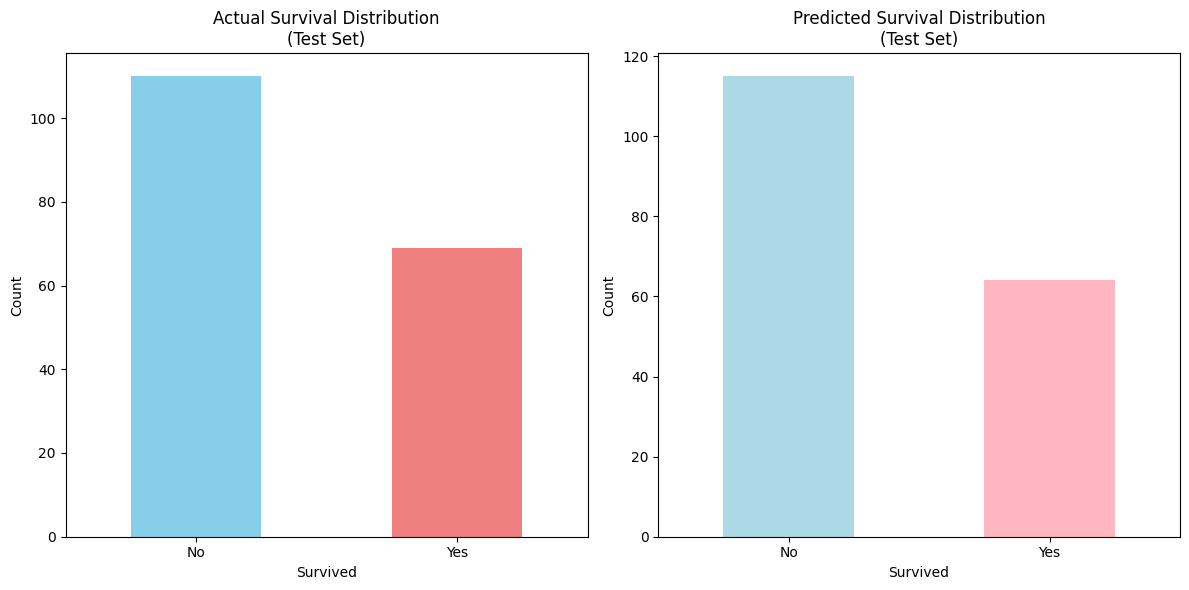

In [100]:
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Correct': y_test.values == y_pred
})

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
comparison_df['Actual'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Actual Survival Distribution\n(Test Set)')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.subplot(1, 2, 2)
comparison_df['Predicted'].value_counts().plot(kind='bar', color=['lightblue', 'lightpink'])
plt.title('Predicted Survival Distribution\n(Test Set)')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.savefig('id3_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

Accuracy: 84.92%
------------------------------
                 precision    recall  f1-score   support

Did Not Survive       0.86      0.90      0.88       110
       Survived       0.83      0.77      0.80        69

       accuracy                           0.85       179
      macro avg       0.84      0.83      0.84       179
   weighted avg       0.85      0.85      0.85       179



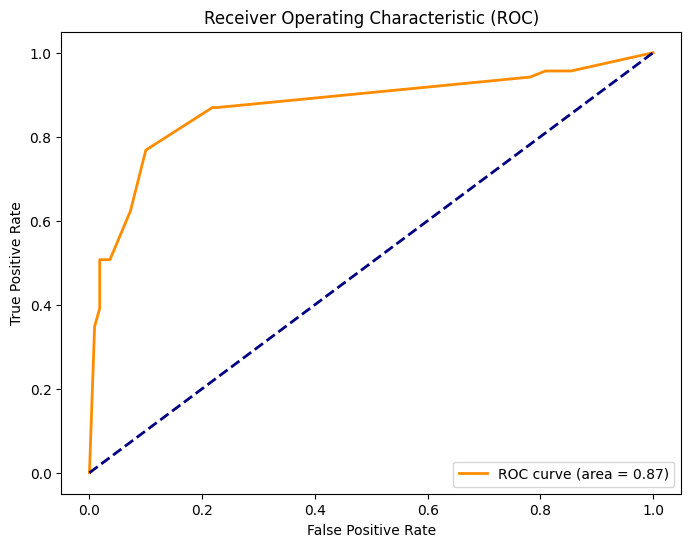

In [101]:

acc = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {acc * 100:.2f}%")
print("-" * 30)
print(classification_report(y_test, y_pred, target_names=['Did Not Survive', 'Survived']))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix


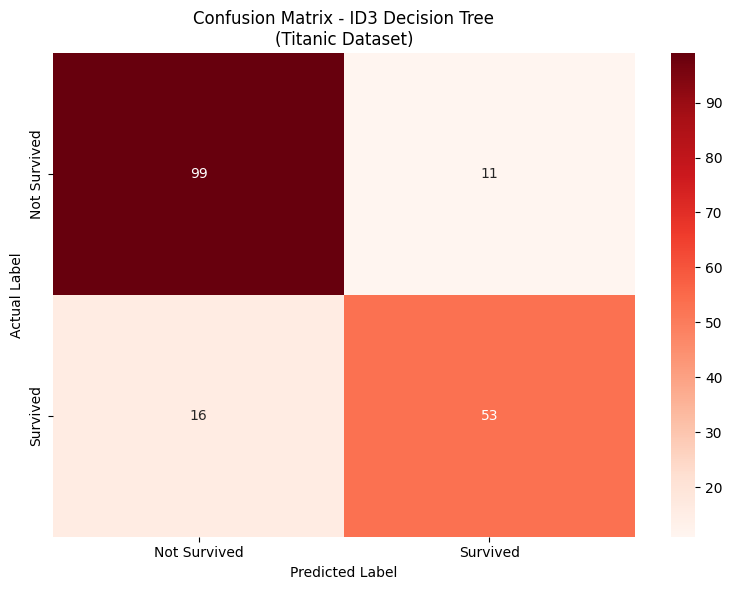

In [102]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix - ID3 Decision Tree\n(Titanic Dataset)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

plt.show()

In [103]:
# Pclass	Sex	Age	SibSp	Parch	Fare	Title_Miss.	Title_Mr.	Title_Mrs.	Title_Rare	Embarked_Q	Embarked_S
def predict_user_input():
    print("\nEnter passenger details to predict survival:")
    try:
        p_class = int(input("Pclass: "))
        sex = input("Sex (male, female): ").strip().lower()
        age = float(input("Age: "))
        sibsp = int(input("SibSp: "))
        parch = int(input("Parch: "))
        fare = float(input("Fare: "))
        embarked = input("Embarked: ").strip().upper()
        title = input("Title: ").strip()

        # Create DataFrame with Initial Features
        input_data = {
            'Pclass': [p_class],
            'Sex': [1 if sex == 'female' else 0], # Map female:1, male:0
            'Age': [age],
            'SibSp': [sibsp],
            'Parch': [parch],
            'Fare': [fare]
        }

        # (One-Hot Encoding)
        # Initialize all dummy columns to 0
        dummy_cols = ['Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_Rare', 'Embarked_Q', 'Embarked_S']
        for col in dummy_cols:
            input_data[col] = [0]

        # Set Title dummy
        t_clean = title.replace('.', '')
        title_map = {
            'Miss': 'Title_Miss.',
            'Mr': 'Title_Mr.',
            'Mrs': 'Title_Mrs.',
            'Rare': 'Title_Rare'
        }
        if t_clean in title_map:
            input_data[title_map[t_clean]] = [1]

        # Set Embarked dummy
        emb_map = {'Q': 'Embarked_Q', 'S': 'Embarked_S'}
        if embarked in emb_map:
            input_data[emb_map[embarked]] = [1]

        # Create DataFrame & Ensure correct column order
        input_df = pd.DataFrame(input_data)
        model_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_Rare', 'Embarked_Q', 'Embarked_S']
        input_df = input_df[model_cols]

        # Scale
        input_df[['Age', 'Fare']] = sc.transform(input_df[['Age', 'Fare']])

        # Predict
        prediction = model.predict(input_df)[0]
        pred_proba = model.predict_proba(input_df)[0]

        outcome = "Survived" if prediction == 1 else "Did Not Survive"
        print(f"\nPrediction: {outcome}")
        print(f"Probability of Survival: {pred_proba[1]:.2%}")

    except Exception as e:
        print(f"An error occurred: {e}")

predict_user_input()


Enter passenger details to predict survival:
Pclass: 3
Sex (male, female): male
Age: 20
SibSp: 1
Parch: 0
Fare: 1002
Embarked: 
Title: Mr

Prediction: Did Not Survive
Probability of Survival: 44.44%
